# [Exp_07] 고양이 수염 스티커 만들기

1. 라이브러리 로드

In [73]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 
import imutils # 이미지 회전 라이브러리
import math as m
import time


2. 이미지 데이터 로드

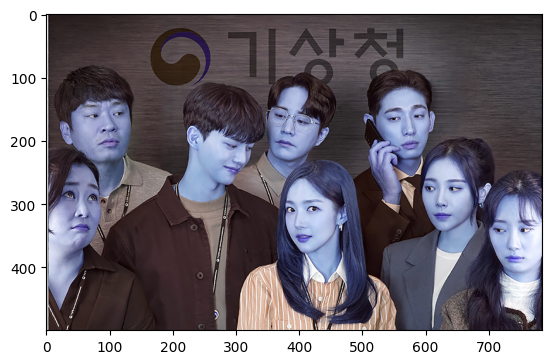

In [88]:
# my_image_path = "/home/evergrin/python/notebook/data/camera_sticker/images/image.png"
# 여러명이 있는 이미지 사용.
my_image_path = "/home/evergrin/python/notebook/data/camera_sticker/images/people2.png"
img_bgr = cv2.imread(my_image_path)

#alpha channel정보를 남기기 위해 cv2.IMREAD_UNCHANGED 추가.
crown_path = "/home/evergrin/python/notebook/data/camera_sticker/images/king.png"
cat_path = "/home/evergrin/python/notebook/data/camera_sticker/images/cat-whiskers.png"
img_crown = cv2.imread(crown_path, cv2.IMREAD_UNCHANGED)
img_cat = cv2.imread(cat_path, cv2.IMREAD_UNCHANGED)

model_path = "/home/evergrin/python/notebook/data/camera_sticker/models/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

plt.imshow(img_bgr)
plt.show()

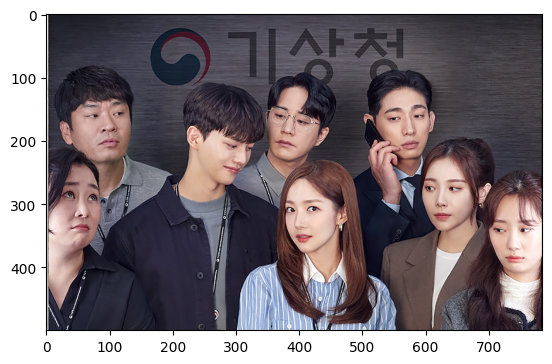

In [89]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

3. face 검출이 가장 잘되는 각도 찾기

In [90]:
# 두점으로 x축과의 기울기 구하기.
def rad_to_degree(rad):
    return rad*180/np.pi

def degree_to_rad(deg):
    return deg*np.pi/180

def angle(p1, p2):
    rad = m.atan2( p2[1] - p1[1], p2[0] - p1[0])
    return rad

def rotate(p, pb, rad):
    rot_mat = np.array([np.cos(rad), -np.sin(rad), np.sin(rad), np.cos(rad)])
    rot_mat = rot_mat.reshape(2, 2)
    pos_mat = np.array([p[0]-pb[0], p[1]-pb[1]])
    # print(rot_mat.shape, pos_mat)
    x, y = np.dot(rot_mat, pos_mat) + np.array([pb[0], pb[1]])
    return (int(x), int(y))


In [91]:
def detect_face(img):
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img, 1)

    print("face count: %d" % (len(dlib_rects)))

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        
        cv2.rectangle(img, (l, t), (r, b), (0, 2555, 0), 2, lineType=cv2.LINE_AA)
        
    return dlib_rects


In [92]:
def detect_face_from_img(img):
    dlib_rects = detect_face(img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()



rotate: 0
face count: 7


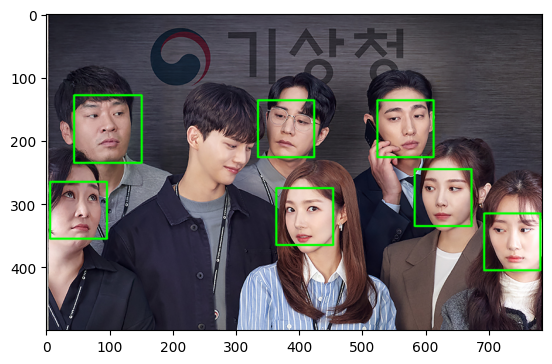

rotate: 30
face count: 7


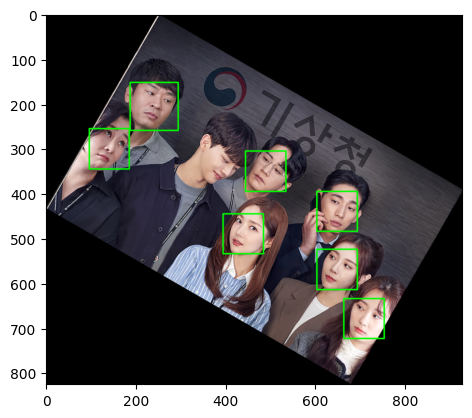

rotate: 60
face count: 0


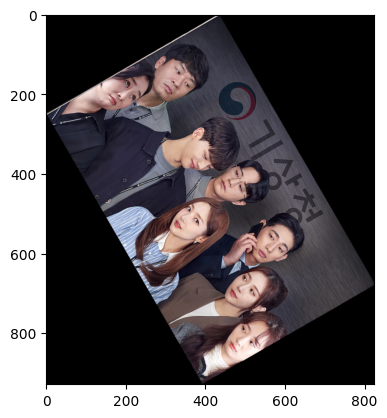

rotate: 90
face count: 0


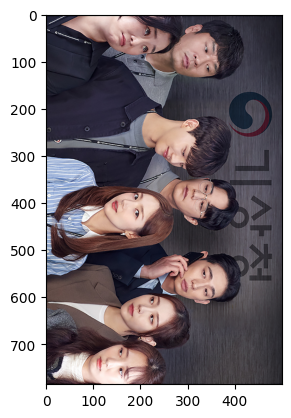

rotate: 120
face count: 1


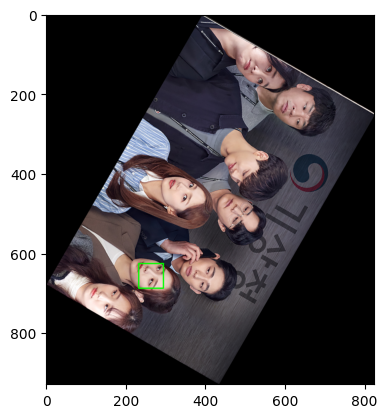

rotate: 150
face count: 0


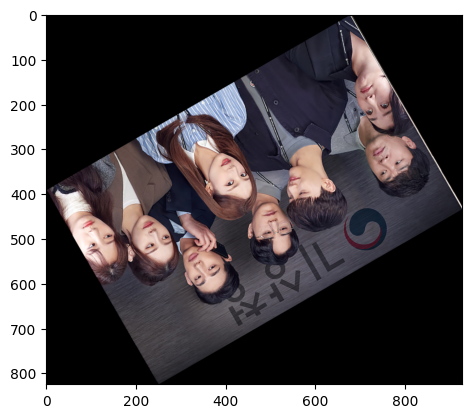

rotate: 180
face count: 0


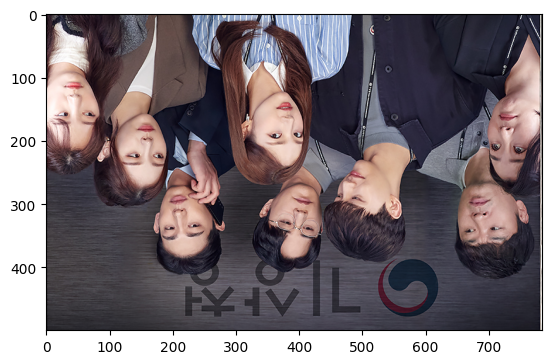

rotate: 210
face count: 0


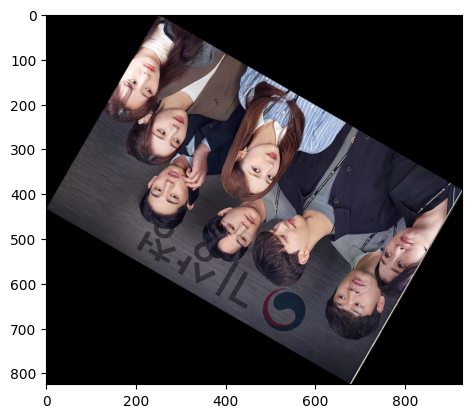

rotate: 240
face count: 0


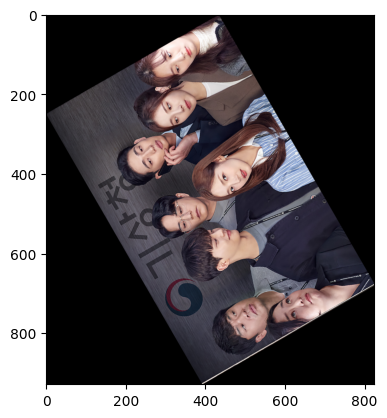

rotate: 270
face count: 0


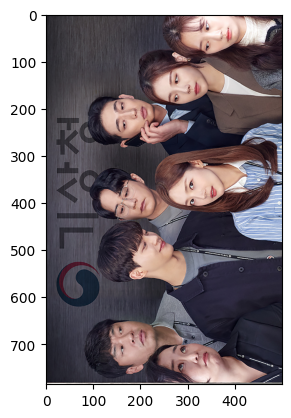

rotate: 300
face count: 1


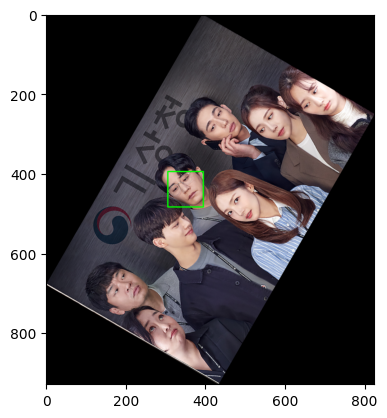

rotate: 330
face count: 8


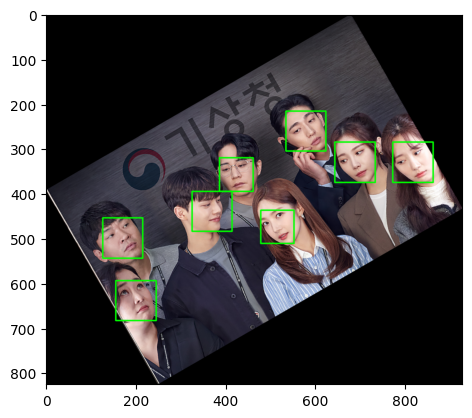

In [93]:
for deg in range(0, 360, 30):
    rotated_img = imutils.rotate_bound(img_bgr, deg)
    print("rotate:", deg)
    detect_face_from_img(rotated_img)
    # time.sleep(1)
    

face count: 8


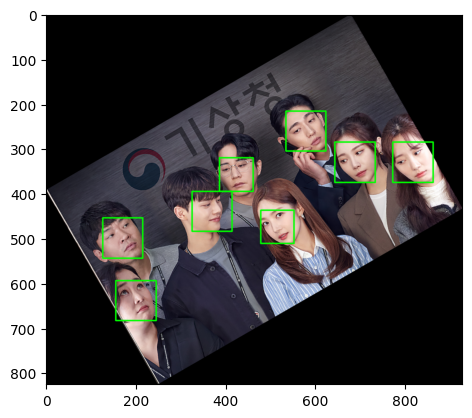

In [94]:
# 얼굴을 가장 많이 디텍트한 330도 회전 사용.
img_bgr = cv2.imread(my_image_path)
img_bgr = imutils.rotate_bound(img_bgr, 330)
img_show = img_bgr.copy()

dlib_rects = detect_face(img_bgr)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

4. 얼굴이 틀어진 만큼 회전하여 스티커 붙이기

In [95]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    print(type(points.parts()))
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

<class '_dlib_pybind11.points'>
<class '_dlib_pybind11.points'>
<class '_dlib_pybind11.points'>
<class '_dlib_pybind11.points'>
<class '_dlib_pybind11.points'>
<class '_dlib_pybind11.points'>
<class '_dlib_pybind11.points'>
<class '_dlib_pybind11.points'>
68


In [96]:
def image_draw_base(nose_top_point, nose_bottom_point):
    draw_base_x = nose_top_point[0] - (nose_bottom_point[0] - nose_top_point[0])
    draw_base_y = nose_top_point[1] - ( nose_bottom_point[1] - nose_top_point[1])
    return (draw_base_x, draw_base_y)

In [97]:
def image_rotate_degree(nose_top_point, nose_bottom_point):
    
    rad = m.atan2( nose_bottom_point[1] - nose_top_point[1], nose_bottom_point[0] - nose_top_point[0])
    deg = rad_to_degree(rad)
    return rad
  

In [98]:
def draw_sticker(img, sticker, base_point, degree, iw, ih):
    
    resized_sticker = cv2.resize(sticker, (iw,ih))
    rotated_sticker = imutils.rotate_bound(resized_sticker, degree)
    h, w = rotated_sticker.shape[:2]
    
    base_x = base_point[0]
    base_y = base_point[1]
    
    l = int(base_x - w/2)
    r = int(base_x + w/2)
    t = int(base_y - h)
    b = int(base_y)
    # cv2.circle(img, (l,t), 3, (0, 0, 255), -1)
    # cv2.circle(img, (r,b), 3, (0, 255, 0), -1)
    
    nb_x, nb_y = rotate((iw/2, ih), (iw/2, ih/2), degree_to_rad(degree))
    
    ncX, ncY = w//2, h//2

    ny = int(ncY - ih/2 + nb_y)
    nx = int(ncX - iw/2 + nb_x)

    l = int(base_x - nx)
    r = int(l + w)
    t = int(base_y - ny)
    b = int(base_y - ny + h)

    # 고양이 수염은 alpha가 적용되지 않아서 alpha채널을 따로 읽어서 rgb에 적용함.
    sticker_area = img[t:t + h, l:l+w, :3]
    rotated_sticker_area = rotated_sticker[:, :, :3]
    rotated_sticker_area = cv2.addWeighted(rotated_sticker_area, 0.1, rotated_sticker_area, 0.1, 0)
    alpha_channel = rotated_sticker[:, :, 3]
    r_channel = rotated_sticker[:, :, 0]
    g_channel = rotated_sticker[:, :, 1]
    b_channel = rotated_sticker[:, :, 2]
    
    for i in range(0, 3):
        img_channel = rotated_sticker[:, :, i]
        rotated_sticker[:, :, i] = np.where(alpha_channel==0, 0, img_channel).astype(np.uint8)    

    sticker_area = img[t:t + h, l:l+w, :3]
    rotated_sticker_area = rotated_sticker[:, :, :3]
    
    img[t:t+h, l:l+w] = np.where(rotated_sticker_area==0, sticker_area, rotated_sticker_area).astype(np.uint8)


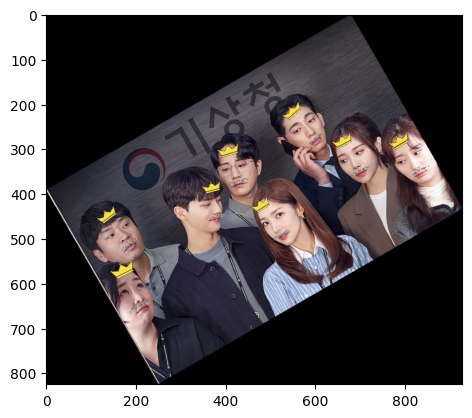

In [99]:
for landmark in list_landmarks:
    left_eye = landmark[36]
    right_eye = landmark[45]
    nose_top = landmark[27]
    nose_bottom = landmark[33]
    lip_top = landmark[51]
    lip_bottom = landmark[57]
    
    # 스티커를 붙이는 기본 좌표들.
    # cv2.circle(img_show, left_eye, 3, (0, 255, 255), -1)
    # cv2.circle(img_show, right_eye, 3, (0, 255, 255), -1)
    # cv2.circle(img_show, nose_top, 3, (255, 0, 0), -1)
    # cv2.circle(img_show, nose_bottom, 3, (255, 0, 0), -1)
    
    cat_x = int((lip_top[0] + nose_bottom[0])/2)
    cat_y = int((lip_top[1] + nose_bottom[1])/2)
    cat_point = (cat_x, cat_y)
    cat_point = (lip_bottom[0], lip_bottom[1])
    
    crown_point = image_draw_base(nose_top, nose_bottom)
    # cv2.circle(img_show, crown_point, 2, (0, 0, 255), -1)
    
    # 얼굴이 틀어진 각도를 계산.
    rotate_rad = image_rotate_degree(nose_top, nose_bottom)
    rotate_deg = rad_to_degree(rotate_rad) - 90
    
    # 그릴 스티커 크기계산.
    w = right_eye[0] - left_eye[0]
    h = nose_bottom[1] - nose_top[1]
    
    # 기본 위치를 기준으로 회전을 적용하여 왕관과 고양이 수염을 그림.
    draw_sticker(img_show, img_crown, crown_point, rotate_deg, w, h)
    draw_sticker(img_show, img_cat, cat_point, rotate_deg, w, h)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()    

5. 회고

- dlib의 pre-trained 데이터와 이미지를 이용하여 간단한 스티커를 만들어 보는 유익한 시간이었다.  
- dlib의 face-detection은 45도 정도 얼굴이 틀어지면 인식되지 않는 문제가 발생했다. 너무 작거나, 만화처럼 단순화된 얼굴도 인식이 되지 않았다.  
- 단순히 얼굴이 틀어져서 인식 안된부분은 이미지를 회전하면서 얼굴로 인식된 부분에 스티커를 붙여주기를 반복하면 가능할 것으로 생각된다. 하지만, 회전하게되면 이미지의 크기가 바뀌면서 위치가 변경되기 때문에 이에 대한 보정이 필요하다. 또한 중복 인식되지 않도록 인식된 부분인지 확인하는 코드가 필요하다.  
- 또한 얼굴 좌우로 돌아간 정도는 양쪽 눈의 위치를 비교하여 cv2의 transform을 사용하면 대략적 구현이 가능할 것으로 생각된다.  
- 고양이 수염은 기존 코드에서는 alpha값이 제대로 동작하지 않아 투명한 부분이 하얗게 나오는 문제가 있었는데 이미지 로드시 cv2.IMREAD_UNCHANGED를 추가하고, alpha채널을 사용하여 해결하였다.  
- 이번 프로젝트에서는 이미지를 30도씩 회전하면서 인식이 되는 부분을 확인하였고, 얼굴이 틀어진 부분을 콧날의 각도를 이용하여 스티커를 회전하고, 스티커가 회전되어 이동된 위치만큼 위치를 보정하여 붙여 주도록 하였다.  
- 이미지에 스티커를 붙이는 것도 쉽지 않았는데, 동영상에 대해서 실시간 처리를 하려면 많은 성능 개선이 필요해 보입니다.